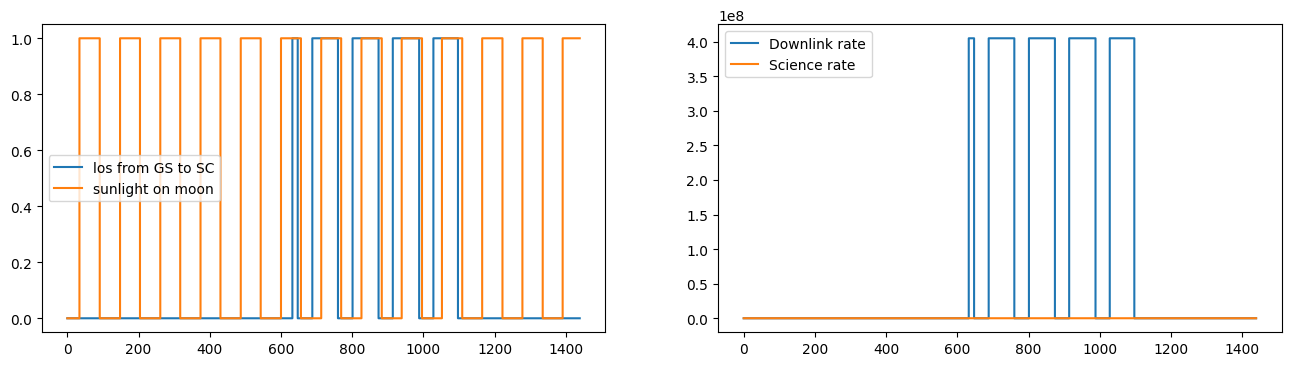

In [1]:
import pickle
with open('./tmp/los.pickle', 'rb') as f:
    los_sc = pickle.load(f)
with open('./tmp/som.pickle', 'rb') as f:
    sun_light = pickle.load(f)
with open('./tmp/rs.pickle', 'rb') as f:
    Rsc = pickle.load(f)
with open('./tmp/rd.pickle', 'rb') as f:
    Rdl = pickle.load(f)

N = len(los_sc)

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16,4))
ax0, ax1 = fig.subplots(1,2)
ax0.step(range(N), los_sc, label='los from GS to SC')
ax0.step(range(N), sun_light, label ='sunlight on moon')
ax0.legend()

ax1.step(range(N), Rdl, label='Downlink rate')
ax1.step(range(N), Rsc, label='Science rate')
ax1.legend()
plt.show()


In [2]:
class DL_optimizer:
    def __init__(self, sos, los, Rsc, Rdl, groundstation_booking_time, ):
        if len(sos) != len(los):
            raise ValueError("Sunlight On Spacecraft (sos) must be same length as Line-Of-Sight (los)")
        self.length = len(los)
        if len(Rsc) == 1:
            Rsc = [Rsc] * self.length
        if len(Rdl) == 1:
            Rdl = [Rdl] * self.length
        self.sos = sos
        self.los = los
        self.Rsc = Rsc
        self.Rdl = Rdl
    
    def setup(self, M, buffersize, summ_diff):
        self.M = M
        self.buffersize = buffersize
        self.summ_diff = summ_diff
    
    def optimize(self):
        import numpy as np
        import cvxpy as cp
        M = self.M
        buffer_size = self.buffersize
        summ_diff = self.summ_diff
        sun_light = self.sos
        los_sc = self.los
        Rsc = self.Rsc
        Rdl = self.Rdl

        # Decision variables
        T_sc = cp.Variable(N, boolean=True)
        T_dl = cp.Variable(N, boolean=True)
        T_idle = cp.Variable(N, boolean=True)

        # Constraints list
        constraints = []

        # Constraint 1: Must collect data when there is sunligt
        for t in range(N):
            constraints += [T_sc[t] <= sun_light[t]]

        # Constraint 2: Only one variable avaiable at each time step
        constraints += [(T_sc[t] + T_dl[t] + T_idle[t] == 1) for t in range(N)]

        # Constraint 3: We cannot transmit what we have not scienced
        for t in range(1, N):
            constraints += [
                cp.sum(cp.multiply(T_dl[:t], Rdl[:t])) <= cp.sum(cp.multiply(T_sc[:t ], Rsc[:t]))
            ]

        # Constraint 4: At the end we must transmit approximately what we science
        end_buffer = cp.Variable(nonneg = True)
        dl_total = cp.Variable(nonneg = True)
        constraints += [dl_total == cp.sum(cp.multiply(T_dl, Rdl))]

        constraints += [end_buffer == cp.sum(cp.multiply(T_sc, Rsc)) - cp.sum(cp.multiply(T_dl, Rdl))]
        constraints += [cp.abs(end_buffer) <= summ_diff]

        for t in range(N):
            constraints += [T_dl[t] <= los_sc[t]]

        # Constraint 5: Buffer size must not be exceeded
        for t in range(1,N):
            constraints += [
                cp.sum(cp.multiply(T_sc[:t], Rsc[:t])) - cp.sum(cp.multiply(T_dl[:t], Rdl[:t])) <= buffer_size
            ]

        # Ground station cappin
        rising_edges = cp.Variable(N, boolean=True)
        falling_edges = cp.Variable(N, boolean=True)
        GS = cp.Variable(N, boolean=True)

        # All initial falling edges must be zero
        for t in range(M):
            constraints += [falling_edges[t] == False]

        for t in range(N - M):
            # Double down on falling edges and rising edges being boolean
            # constraints += [rising_edges[t] <= 1]

            # constraints += [falling_edges[t] <= 1]
            
            #Set falling edges accoring to rising edges
            constraints += [falling_edges[t+M] == rising_edges[t]]

            # if t >= M:
            #     constraints += [falling_edges[t] <= rising_edges[t - M]]

            # # We cannot have a falling edge before a rising
            # constraints += [cp.sum(rising_edges[:t]) >= cp.sum(falling_edges[:t])]

            # There can not be a negative amount of falling edges
            constraints += [(cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])) >= 0]
            constraints += [(cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])) <= 1]

            #constraints += [(cp.cumsum(rising_edges) - cp.cumsum(falling_edges)) >= 0]

            #There can not be more than one GS window at once

        for t in range(N-M, N):
            constraints += [rising_edges[t] == False]
            
        for t in range(N):
            constraints += [GS[t] == cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])]
            constraints += [T_dl[t] <= GS[t]]


        # Objective: minimize total downlink usage
        #objective = cp.Minimize(cp.sum(GS) - sc_total)
        objective = cp.Maximize(dl_total - 0.5*cp.sum(GS))

        # Solve
        problem = cp.Problem(objective, constraints)
        print(cp.installed_solvers())

        # Ensure the CBC solver is installed
        problem.solve(solver=cp.GUROBI, verbose=True)  # Using the CBC solver as an alternative

        # Output
        print("Status:", problem.status)
        print("Total cost :", problem.value)
        print("Total downlined:", dl_total.value)
        print("Total scienced:", sum(T_sc.value * np.array(Rsc)))
        for t in range(N):
            print(f"t={t}: T_sc={T_sc.value[t]:.0f}, T_dl={T_dl.value[t]:.0f}, T_idle={T_idle.value[t]:.0f}, GS={GS.value[t]}")

        return T_sc.value, T_dl.value, T_idle.value, GS.value    

In [3]:
optimizer = DL_optimizer(sun_light, los_sc, Rsc, Rdl, 60)
optimizer.setup(60, 256e9, 1e6)
T_sc, T_dl, T_idle, GS = optimizer.optimize()

['CBC', 'CLARABEL', 'CVXOPT', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'MOSEK', 'OSQP', 'PDLP', 'SCIP', 'SCIPY', 'SCS', 'XPRESS']
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 06 10:23:02 AM: Your problem has 8642 variables, 14341 constraints, and 0 parameters.
(CVXPY) May 06 10:23:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 06 10:23:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 06 10:23:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 06 10:23:02 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
--------------------

SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

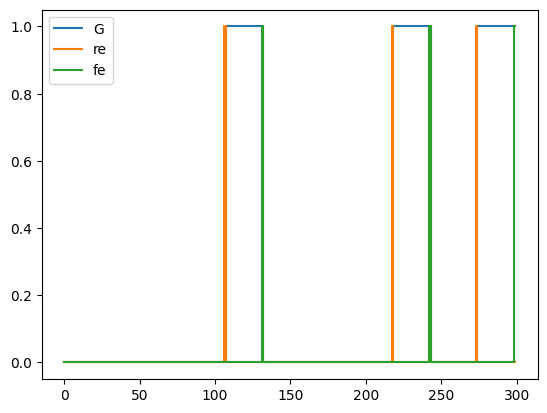

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
T = range(N)
plt.step(T, GS, label = 'G')
#plt.xlim(0,100)
plt.legend()
plt.show()

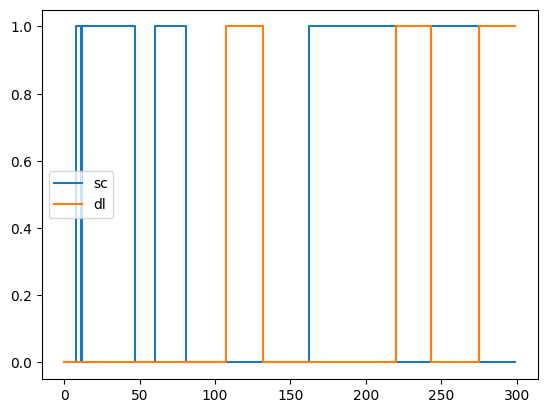

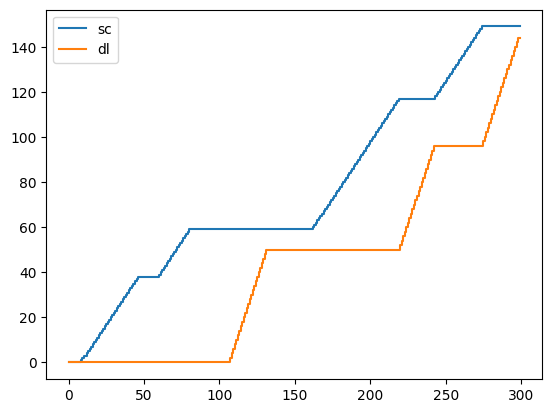

In [ ]:

sc = np.empty(N, np.float16)
dl = np.empty(N, np.float16)
for t in range(N):
    sc[t] = T_sc.value[t]
    dl[t] = T_dl.value[t]  # Extract values from T_dl
sc_cumsum = np.cumsum(sc*Rsc)
dl_cumsum = np.cumsum(dl*Rdl)

plt.step(range(N), sc, label = 'sc')
plt.step(range(N), dl, label = 'dl')
plt.legend()
plt.show()
plt.step(range(N), sc_cumsum, label = 'sc')
plt.step(range(N), dl_cumsum, label = 'dl')
plt.legend()
plt.show()

In [ ]:
atoms = problem.atoms()
for a in atoms:
    print(a)
constrain = problem.constraints
for c in constrain:
    print(c)

<class 'cvxpy.atoms.affine.sum.Sum'>
<class 'cvxpy.atoms.affine.unary_operators.NegExpression'>
<class 'cvxpy.atoms.affine.binary_operators.multiply'>
<class 'cvxpy.atoms.affine.add_expr.AddExpression'>
<class 'cvxpy.atoms.affine.index.index'>
<class 'cvxpy.atoms.elementwise.abs.abs'>
var453680[0] <= 0.0
var453680[1] <= 0.0
var453680[2] <= 0.0
var453680[3] <= 0.0
var453680[4] <= 0.0
var453680[5] <= 0.0
var453680[6] <= 0.0
var453680[7] <= 0.0
var453680[8] <= 0.0
var453680[9] <= 0.0
var453680[10] <= 0.0
var453680[11] <= 0.0
var453680[12] <= 0.0
var453680[13] <= 0.0
var453680[14] <= 0.0
var453680[15] <= 0.0
var453680[16] <= 0.0
var453680[17] <= 0.0
var453680[18] <= 0.0
var453680[19] <= 0.0
var453680[20] <= 0.0
var453680[21] <= 0.0
var453680[22] <= 0.0
var453680[23] <= 0.0
var453680[24] <= 0.0
var453680[25] <= 0.0
var453680[26] <= 0.0
var453680[27] <= 0.0
var453680[28] <= 0.0
var453680[29] <= 1.0
var453680[30] <= 1.0
var453680[31] <= 1.0
var453680[32] <= 1.0
var453680[33] <= 1.0
var453680[